![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Legal/8.Answering_Questions_Legal_Texts.ipynb)

# Answering Questions on Legal Texts
One of the latests biggest outcomes in NLP are **Language Models** and their ability to answer questions, expressed in natural language.

> *In February 2017, the Company entered into an asset purchase agreement with NetSeer, Inc.
...
 The Company hereby grants to Seller a perpetual, non-exclusive, royalty-free license.
...
On March 12, 2020, we closed a Loan and Security Agreement with Hitachi Capital American Corp (also known as "Hitachi")
...*




```
- What is the type of agreement?
- What is the type of license?
- What are the companies in the agreement?
- What is also known as the different compaines?
- Who is the recipient of a license?
````

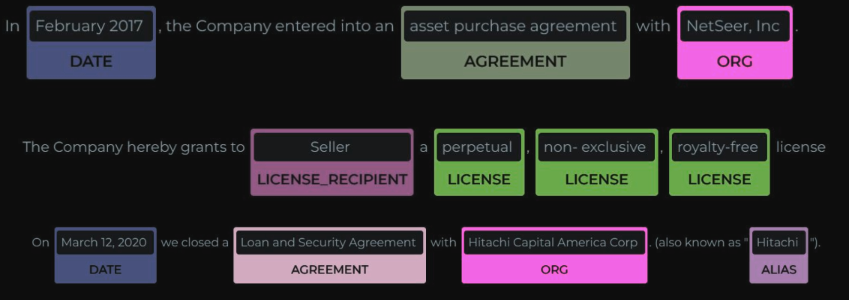



**Question Answeering (QA)** uses specific Language Models trained to carry out **Natural Language Inference (NLI)**

**NLI** works as follows:
- Given a text as a Premise (P);
- Given a hypotheses (H) as a question to be solved;
   - Then, we ask the Language Model is H is `entailed`, `contradicted` or `not related` in P. 


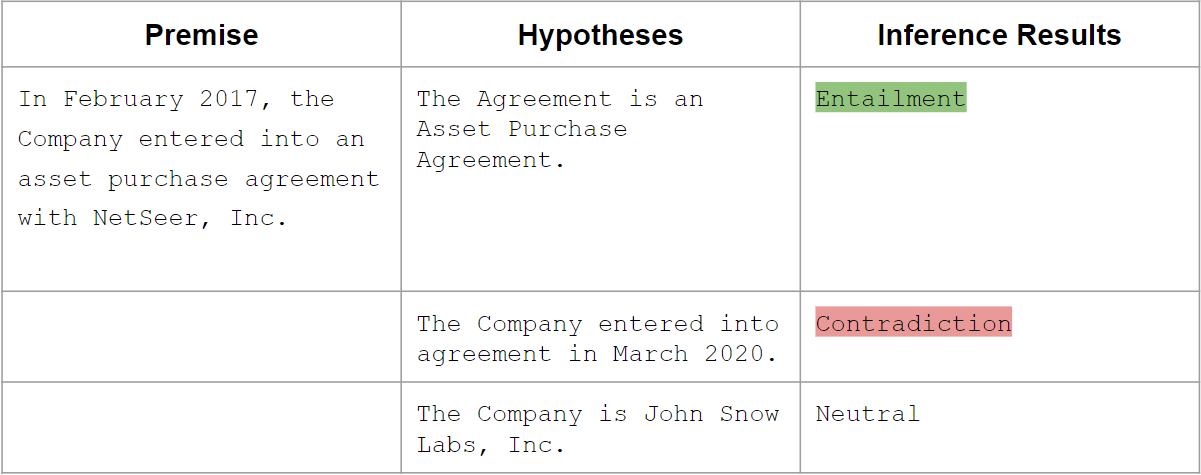

Although we are not getting into the maths of it, it's basically done by using a Language Model to encode P, H and then carry out sentence similarity operations.

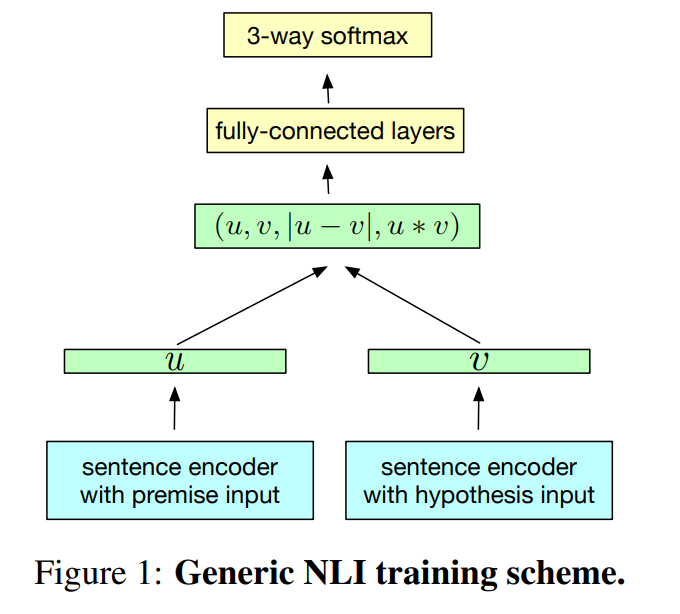

## Applications of NLI: The basics
The most straight-forward, retrieving answers to natural language questions.
  - Type 1: Open-book questions, where you give the text (P) to the model.
  - Type 2: Close-book questions, where you just use the pretrained Language Model capabilities, learn on texts during training time.

## Applications of NLI: Zero-shot
At John Snow Labs, we have developed our own annotators based on NLI, to not only carry out Question Answering, but using QA to:
- Retrieve Entities, also know as Zero-shot NER;
- Retrieve Relations, also known as Zero-shot Relation Extraction;

### How we achieve Zero-shot NER With QA?
Given a Question Q, for example, `What is the type of the agreement?`, and given the text P `In February 2017, the Company entered into an Asset Purchase Agreement with NetSeer, Inc.` we:

- Generate Hypotheses H with the tokens of the text
  - The type of agreement is February: `contradiction`
  - The type of agreement is 2017: `contradiction`
  - The type of agreement is ...: `contradiction`
  - The type of agreement is Asset: `entailment`
  - The type of agreement is Purchase: `entailment`

- We check all the H towards P to see if they are `entailed`. If so, we return them as NER entity. If several tokens in a row return `entailed`, we check if they can be part of the same chunk.

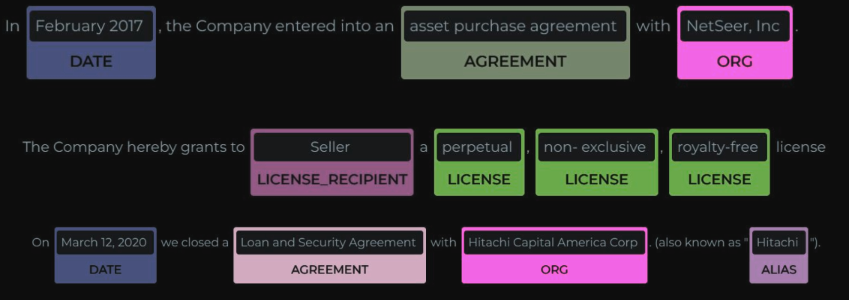

Let's take a look at some examples of applications of QA to Legal Texts.

# Colab Setup

In [1]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install johnsnowlabs 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from johnsnowlabs import nlp, legal
nlp.install(force_browser=True)

<IPython.core.display.Javascript object>

127.0.0.1 - - [03/Jan/2023 13:23:11] "GET /login?code=m6QjI9OHYIvlz0nbJBSLeybroBPEFm HTTP/1.1" 200 -


<IPython.core.display.Javascript object>

Licenses extracted successfully
👌 JSL-Home is up to date! 
👌 Everything is already installed, no changes made


# Start Spark Session

In [3]:
from johnsnowlabs import nlp, legal
# Automatically load license data and start a session with all jars user has access to
spark = nlp.start()

👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.2.4, 💊Spark-Healthcare==4.2.4, running on ⚡ PySpark==3.1.2


# Open Book Questions

In [4]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings_JSL/Legal/data/credit_agreement.txt

--2023-01-03 13:24:02--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings_JSL/Legal/data/credit_agreement.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405174 (396K) [text/plain]
Saving to: ‘credit_agreement.txt.4’

credit_agreement.tx 100%[===================>] 395.68K  --.-KB/s    in 0.02s   

2023-01-03 13:24:02 (17.8 MB/s) - ‘credit_agreement.txt.4’ saved [405174/405174]



In [5]:
with open('credit_agreement.txt', 'r') as f:
  credit_agreement = f.read()

In [6]:
print(credit_agreement[:1000])



                                                                    Exhibit 10.1

                                                                  EXECUTION COPY

                    $225,000,000.00 REVOLVING CREDIT FACILITY

                                CREDIT AGREEMENT

                                  by and among

                             P.H. GLATFELTER COMPANY

                                       and

                    Certain of its Subsidiaries, as Borrowers

                                       and

                       THE BANKS PARTY HERETO, as Lenders

                                       and

             PNC BANK, NATIONAL ASSOCIATION, as Administrative Agent

                                      with

           PNC CAPITAL MARKETS LLC and CITIZENS BANK OF PENNSYLVANIA,

                  as Joint Lead Arrangers and Joint Bookrunners

                                       and

               CITIZENS BANK OF PENNSYLVANIA, as Syndication Agent

   

Let's read and normalize a little the spacing of the NLP models may think those are different sentences and get unexpected results.

In [7]:
import re
normalized_intro = re.sub(r'\s+', ' ', credit_agreement[:1000])
normalized_intro

' Exhibit 10.1 EXECUTION COPY $225,000,000.00 REVOLVING CREDIT FACILITY CREDIT AGREEMENT by and among P.H. GLATFELTER COMPANY and Certain of its Subsidiaries, as Borrowers and THE BANKS PARTY HERETO, as Lenders and PNC BANK, NATIONAL ASSOCIATION, as Administrative Agent with PNC CAPITAL MARKETS LLC and CITIZENS BANK OF PENNSYLVANIA, as Joint Lead Arrangers and Joint Bookrunners and CITIZENS BANK OF PENNSYLVANIA, as Syndication Agent '

In [8]:
normalized_intro = "Exhibit 10.1 EXECUTION COPY $225,000,000.00 REVOLVING CREDIT FACILITY CREDIT AGREEMENT by and among P.H. GLATFELTER COMPANY and Certain of its Subsidiaries, as Borrowers and THE BANKS PARTY HERETO, as Lenders and PNC BANK, NATIONAL ASSOCIATION, as Administrative Agent with PNC CAPITAL MARKETS LLC and CITIZENS BANK OF PENNSYLVANIA, as Joint Lead Arrangers and Joint Bookrunners and CITIZENS BANK OF PENNSYLVANIA, as Syndication Agent."

## Let's create a pipeline
Any of those models in Models Hub should be good. We will pick `Bert` (large).


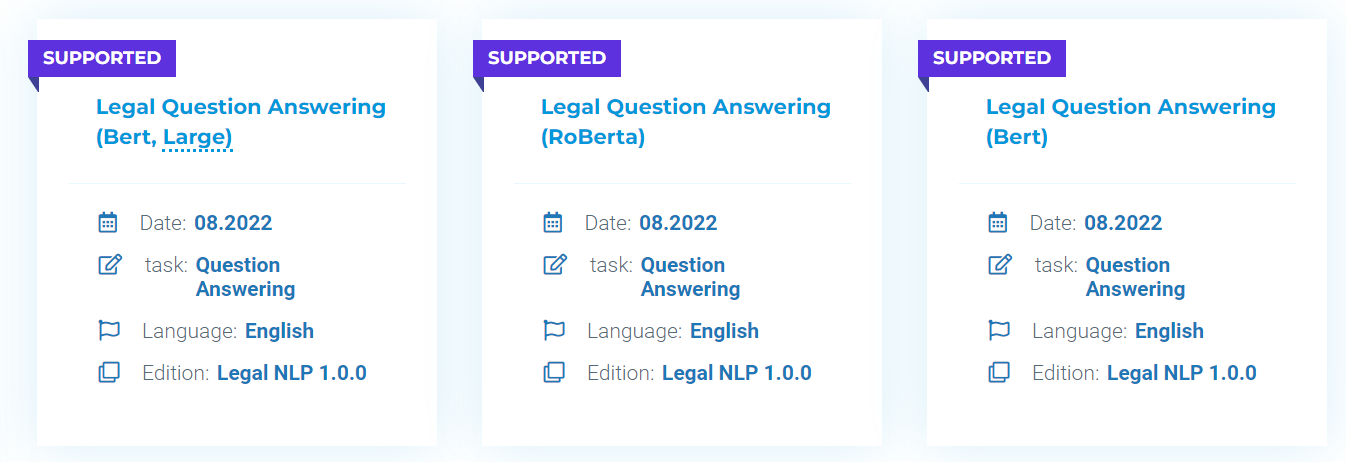

To do that, we use in our pipelines:
- a `MultiDocumentAssembler`, which puts together questions (Q to create H) and context (P).
- a BertForQuestionAnswering pretrained model. 

**IMPORTANT: We highly recommend to use `setCaseSensitive(False)` to prevent uppercase to be managed as proper nouns and possibly trigger OOV.**

In [9]:
documentAssembler = nlp.MultiDocumentAssembler()\
  .setInputCols(["question", "context"])\
  .setOutputCols(["document_question", "document_context"])

spanClassifier = nlp.BertForQuestionAnswering.pretrained("legqa_bert_large","en", "legal/models") \
  .setInputCols(["document_question", "document_context"]) \
  .setOutputCol("answer") \
  .setCaseSensitive(False) # IMPORTANT 

qa_pipeline = nlp.Pipeline().setStages([
  documentAssembler,
  spanClassifier
])

legqa_bert_large download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


In [10]:
P = normalized_intro

Q = [
     "What is the agreement type?", 
     "Who is signing the agreement?",
     "Is there any bank mentioned?",
     "Who is the Borrower?",
     "Who are the Lenders?",
     "Is this document a copy?",
     "What is the number of Exhibit?",
     "What is the amount of the credit?"
     ]

Q_P = [ [q, P] for q in Q]

example = spark.createDataFrame(Q_P).toDF("question", "context")

example.show()

+--------------------+--------------------+
|            question|             context|
+--------------------+--------------------+
|What is the agree...|Exhibit 10.1 EXEC...|
|Who is signing th...|Exhibit 10.1 EXEC...|
|Is there any bank...|Exhibit 10.1 EXEC...|
|Who is the Borrower?|Exhibit 10.1 EXEC...|
|Who are the Lenders?|Exhibit 10.1 EXEC...|
|Is this document ...|Exhibit 10.1 EXEC...|
|What is the numbe...|Exhibit 10.1 EXEC...|
|What is the amoun...|Exhibit 10.1 EXEC...|
+--------------------+--------------------+



In [11]:
result = qa_pipeline.fit(example).transform(example)

result.select('question', 'answer.result', 'answer').show(truncate=False)

+---------------------------------+--------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|question                         |result                                                                                                                    |answer                                                                                                                                                                                                                                                                    |
+---------------------------------+-----------------------------------------------------------------------------------------------------------------

# AUTOMATIC QUESTION GENERATION
Now the question is ... is there a way to generate the questions automatically?

The answer is simple: **YES**, there is!

We have several ways to generate a series of questions, given for examplee:
- A `SUBJECT` of a sentence;
- An `ACTION` (verb);

More specifically, there are three ways:
1. Using the grammatical information (Part of Speech and Dependency Tree);
2. Using NER / Contextual Parser or other method to retrieve SUBJECT and VERB, for example, `legner_obligations`..

Check next notebook to see how to do it. Until then, a small spoiler...

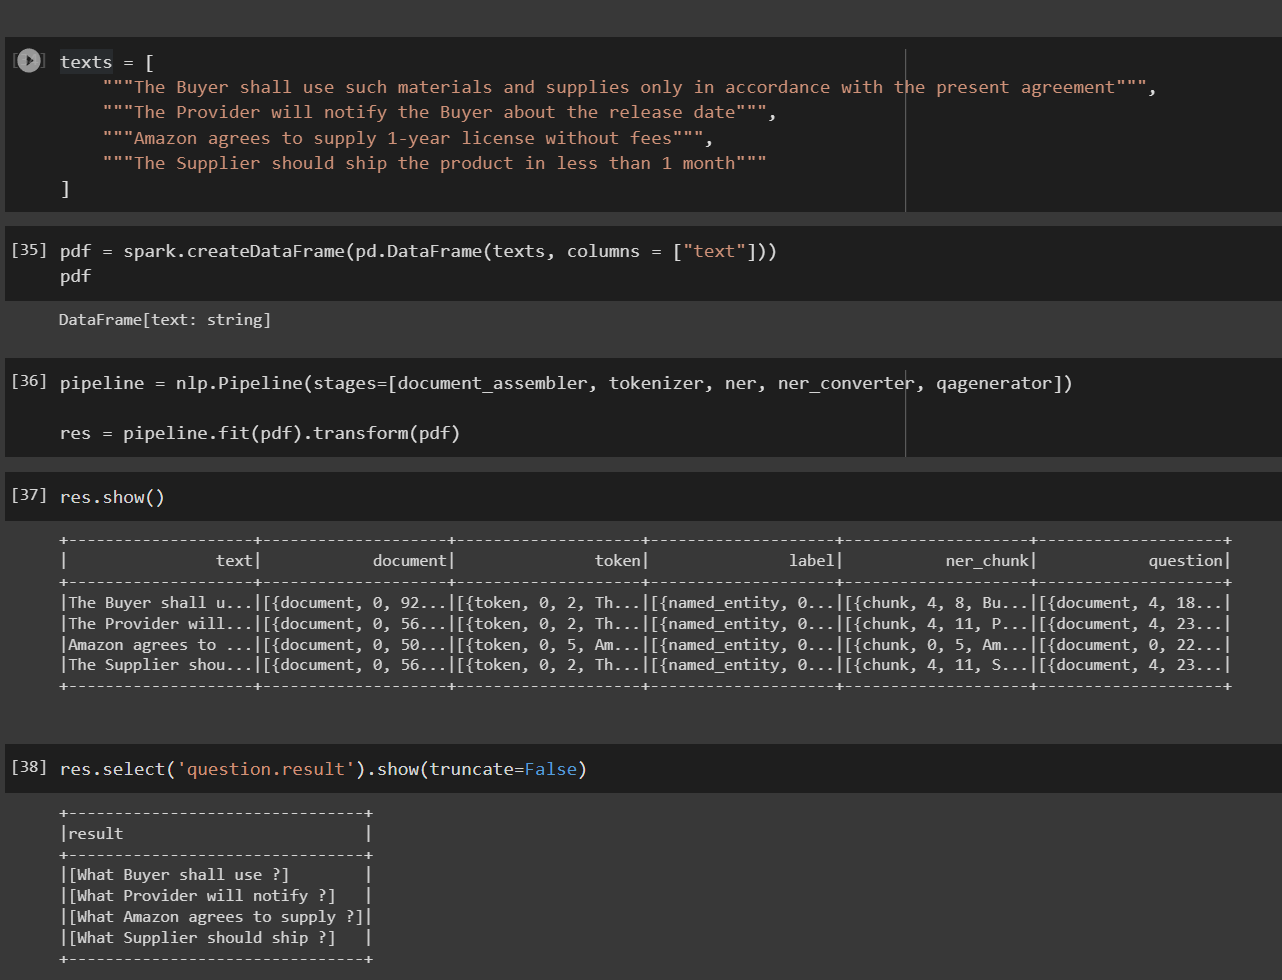

## Table Question Answering
Although it may be not critical for Legal Documents, you may have information in `csv`, `xls` files, or even documents with `tables` on them you want to analyze.

We offer `Table Understanding` (or Table Question Answering) to satisfy those needs. Let's take a look at how it works.

# 1. From csv files

Let's create a `csv` file with information about clients and agreements.

In [79]:
import pandas as pd

df_data = { 
    "header" : ['client name', 'last operation year', 'last operation amount', 'document'],
    "rows" : [    
 ['John Smith', '2007', '$200000', 'NDA'],
 ['Jack Gordon', '2017', '$10000',  'Credit Agreement'],
 ['Mary Lean', '2001', '$120000', 'License Agreement'],
 ['Jessica James', '2022', '$1200000', 'Purchase Agreement'],
]
}


df = pd.DataFrame(df_data['rows'], columns=df_data['header'])

df.to_csv('table.csv', index=False)


In [80]:
df_data

{'header': ['client name',
  'last operation year',
  'last operation amount',
  'document'],
 'rows': [['John Smith', '2007', '$200000', 'NDA'],
  ['Jack Gordon', '2017', '$10000', 'Credit Agreement'],
  ['Mary Lean', '2001', '$120000', 'License Agreement'],
  ['Jessica James', '2022', '$1200000', 'Purchase Agreement']]}

In [48]:
df

,client name,last operation year,last operation amount,document
0,John Smith,2007,$200000,NDA
1,Jack Gordon,2017,$10000,Credit Agreement
2,Mary Lean,2001,$120000,License Agreement
3,Jessica James,2022,$1200000,Purchase Agreement


In [81]:
import json
json.dumps(df_data)

'{"header": ["client name", "last operation year", "last operation amount", "document"], "rows": [["John Smith", "2007", "$200000", "NDA"], ["Jack Gordon", "2017", "$10000", "Credit Agreement"], ["Mary Lean", "2001", "$120000", "License Agreement"], ["Jessica James", "2022", "$1200000", "Purchase Agreement"]]}'

Now, some questions...

In [105]:
queries = [
    "Who signed an NDA?",
    "Who operated last time in 2022?", 
    "What is the total amount of operations?",
    "Which year a Credit Agreement was signed?",
]

Now, we will use the following specific components:
- A `MultiDocumentAssembler`, to put together the questions and the table in `json` format
- A `TableAssembler` to assemble the table from a json

In [106]:
data = spark.createDataFrame([
        [json.dumps(df_data), " ".join(queries)]
    ]).toDF("table_json", "questions")

In [107]:
data.show()

+--------------------+--------------------+
|          table_json|           questions|
+--------------------+--------------------+
|{"header": ["clie...|Who signed an NDA...|
+--------------------+--------------------+



In [108]:
document_assembler = nlp.MultiDocumentAssembler() \
    .setInputCols("table_json", "questions") \
    .setOutputCols("document_table", "document_questions")

sentence_detector = nlp.SentenceDetector() \
    .setInputCols(["document_questions"]) \
    .setOutputCol("questions")

table_assembler = nlp.TableAssembler()\
    .setInputCols(["document_table"])\
    .setOutputCol("table")

Last component is `TapasForQuestionAnswering`, which will carry out the inference process

In [109]:
tapas = nlp.TapasForQuestionAnswering.pretrained("table_qa_tapas_base_finetuned_wtq", "en")\
    .setInputCols(["questions", "table"])\
    .setOutputCol("answers")

table_qa_tapas_base_finetuned_wtq download started this may take some time.
Approximate size to download 394.7 MB
[OK!]


Now the pipeline looks as follows:

In [110]:
pipeline = nlp.Pipeline(stages=[
    document_assembler,
    sentence_detector,
    table_assembler,
    tapas
])

And this is the result on fit/transform:

In [111]:
model = pipeline.fit(data)
res = model\
    .transform(data)\
    .selectExpr("explode(answers) AS answer")\
    .select("answer")
res.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|answer                                                                                                                                                                                                                         |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{chunk, 0, 10, John Smith, {question -> Who signed an NDA?, aggregation -> NONE, cell_positions -> [0, 0], cell_scores -> 1.0}, []}                                                                                            |
|{chunk, 0, 13, Jessica James, {question -> Who operated last time in 2022?, aggregation -> NONE

In [112]:
from pyspark.sql import functions as F
res.select("answer.metadata.question", F.expr('answer.result as answer'), F.expr('answer.metadata["aggregation"] as metadata')).show(truncate=False)

+-----------------------------------------+-----------------------------------------+--------+
|question                                 |answer                                   |metadata|
+-----------------------------------------+-----------------------------------------+--------+
|Who signed an NDA?                       |John Smith                               |NONE    |
|Who operated last time in 2022?          |Jessica James                            |NONE    |
|What is the total amount of operations?  |COUNT($200000, $10000, $120000, $1200000)|COUNT   |
|Which year a Credit Agreement was signed?|2017                                     |NONE    |
+-----------------------------------------+-----------------------------------------+--------+

